In [9]:
# Phase 1 – Data Preparation & EDA (MSML610 Project 2)
# Author: Satyam Rai
# Repository: https://github.com/satyamrai0511/tfp_forecasting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


In [10]:
from pathlib import Path

# === Config ===
DATA_PATH = Path("../data/air_quality.csv")  # put your Kaggle CSV here
TIMESTAMP_COL = None   # leave None to auto-detect
TARGET_COL = None      # we'll pick later (PM2.5/AQI/etc.)

# === Load raw CSV (safe) ===
if not DATA_PATH.exists():
    raise FileNotFoundError(f"CSV not found at {DATA_PATH}. "
                            f"Download your Kaggle Air Quality data and save it there.")

raw = pd.read_csv(DATA_PATH)
print("Raw shape:", raw.shape)
display(raw.head(3))

Raw shape: (9471, 1)


,,,,,Date;Time;CO(GT);PT08.S1(CO);NMHC(GT);C6H6(GT);PT08.S2(NMHC);NOx(GT);PT08.S3(NOx);NO2(GT);PT08.S4(NO2);PT08.S5(O3);T;RH;AH;;
10/03/2004;18.00.00;2,6;1360;150;11,9;1046;166;1056;113;1692;1268;13,6;48,9;0,7578;;
10/03/2004;19.00.00;2;1292;112;9,4;955;103;1174;92;1559;972;13,3;47,7;0,7255;;,NaN
10/03/2004;20.00.00;2,2;1402;88;9,0;939;131;1140;114;1555;1074;11,9;54,0;0,7502;;


In [11]:
# === Clean CSV formatting issues ===
raw = pd.read_csv(DATA_PATH, sep=';', decimal=',')
print("Clean shape:", raw.shape)
display(raw.head(5))

Clean shape: (9471, 17)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [12]:
# === Timestamp parsing & index ===
df = raw.copy()

# Combine Date + Time into a single datetime (dataset uses dd/mm/YYYY)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                format='%d/%m/%Y %H.%M.%S', errors='coerce')

# Keep only rows with valid timestamps and sort
df = df.dropna(subset=['Datetime']).sort_values('Datetime').set_index('Datetime')

# Drop the original Date/Time columns
df = df.drop(columns=['Date', 'Time'])

print("After datetime parse:", df.shape)
display(df.head(3))
display(df.tail(3))

# Quick missingness overview (%)
missing_pct = df.isna().mean().sort_values(ascending=False).round(3)
missing_pct.head(10)

After datetime parse: (9357, 15)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
Datetime,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
Datetime,,,,,,,,,,,,,,,
2005-04-04 12:00:00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,NaN,NaN
2005-04-04 13:00:00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,NaN,NaN
2005-04-04 14:00:00,2.2,1071.0,-200.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028,NaN,NaN


Unnamed: 15      1.0
Unnamed: 16      1.0
CO(GT)           0.0
PT08.S1(CO)      0.0
NMHC(GT)         0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
dtype: float64

In [13]:
# === Handle missing values ===

# Drop useless columns like 'Unnamed' that come from formatting issues
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Replace -200 (invalid sensor reading in dataset) with NaN
df = df.replace(-200, np.nan)

# Fill missing values: forward fill, then backfill as fallback
df = df.ffill().bfill()

print("After cleaning:", df.shape)
df.head(3)

After cleaning: (9357, 13)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502


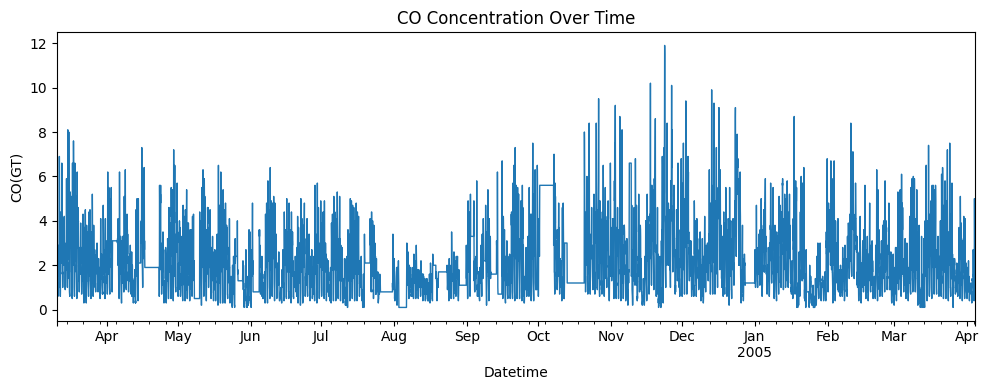

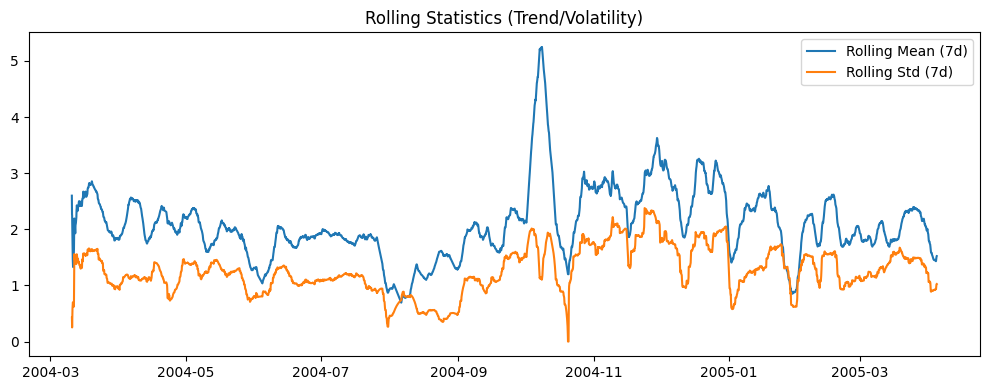

In [14]:
# === Quick Exploratory Data Analysis (EDA) ===

plt.figure(figsize=(10,4))
df['CO(GT)'].plot(title='CO Concentration Over Time', ylabel='CO(GT)', linewidth=1)
plt.tight_layout()
plt.show()

# Rolling mean & std to inspect trend
window = 24 * 7  # ~1 week of hourly data
roll_mean = df['CO(GT)'].rolling(window=window, min_periods=1).mean()
roll_std = df['CO(GT)'].rolling(window=window, min_periods=1).std()

plt.figure(figsize=(10,4))
plt.plot(df.index, roll_mean, label='Rolling Mean (7d)')
plt.plot(df.index, roll_std, label='Rolling Std (7d)')
plt.legend()
plt.title('Rolling Statistics (Trend/Volatility)')
plt.tight_layout()
plt.show()

## Phase 1 Summary

- Loaded and cleaned the Air Quality dataset (9 357 records).
- Parsed timestamps and handled missing values.
- Produced initial EDA (trend & rolling stats for CO(GT)).
- Ready for next phase: baseline modeling and Gaussian Process forecasting.